# Capstone Project
##Sentiment Analysis on Sentiment 140 Dataset

Develop a sentiment analysis model using Tensorflow that assigns a sentiment looking at the review/chat of the product.

Use pre-built embeddings for your data dictionary

Train the model using Transformer/Attention based architecture 

Reach an overall “precision” score of 85%

Use TF serving to deploy the model as an API (on local)

Build a TF serving client to interact with the API. This client should also be able to continuously accept data entered by the user and provide the sentiment for the review/chat entered by the end-user.

# Importing Libraries

This is where we get BERT model and it's tokenizer

In [ ]:
!pip install Sentencepiece

     |████████████████████████████████| 1.2 MB 7.6 MB/s 


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 6.1 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 6.5 MB 51.0 MB/s 
     |████████████████████████████████| 895 kB 55.6 MB/s 
     |████████████████████████████████| 596 kB 56.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD

# utilities
import re
import pickle


# plotting
import seaborn as sns
from wordcloud import WordCloud


# nltk
from nltk.stem import WordNetLemmatizer



from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Importing Dataset 

The dataset being used is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.


It contains the following 6 fields:

sentiment: the polarity of the tweet (0 = negative, 4 = positive)

ids: The id of the tweet (2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

query: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

We require only the sentiment and text fields, so we discard the rest.

Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/dataset.csv',encoding='latin-1')

In [ ]:
print("There are {} rows and {} columns in data file".format(data.shape[0],data.shape[1]))

There are 1599999 rows and 6 columns in data file


In [ ]:
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


 0 -> Negative
 4 -> Positive

In [ ]:
data.columns = ['class','id','time','query','user','text']
data.head()

,class,id,time,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
data['class'].value_counts()

4    800000
0    799999
Name: class, dtype: int64

In [ ]:
# Removing the unnecessary columns.
data = data[['class','text']]
# Replacing the values to ease understanding.
data['class'] = data['class'].replace(4,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


 0 -> Negative
 1 -> Positive

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

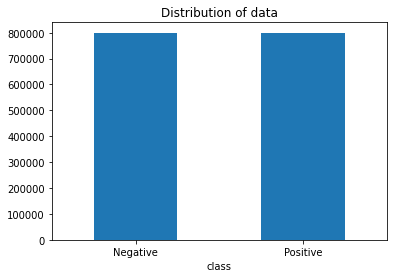

In [ ]:
# Plotting the distribution for dataset.
ax = data.groupby('class').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [ ]:
data.head()

,class,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [ ]:
# Storing data in lists.
text, sentiment = list(data['text']), list(data['class'])

# Pre-processing of text

The Preprocessing steps taken are:

Lower Casing: Each text is converted to lowercase. Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".

Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")

Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")

Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.

Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")

Removing Short Words: Words with length less than 2 are removed.

Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")

Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [ ]:
## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
          if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [ ]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 159 seconds


In [ ]:
processedtext[0]

'upset update facebook texting might cry result school today also blah '

In [ ]:
# Storing processed text in new data1 Dataframe
column_values=['text']
data1 = pd.DataFrame(data = processedtext, 
                  columns = column_values)

In [ ]:
data1.head()

,text
0,upset update facebook texting might cry result...
1,USER dived many time ball managed save 50 rest...
2,whole body feel itchy like fire
3,USER no not behaving mad see over
4,USER not whole crew


In [ ]:
data1['class']=data['class']
data1.head()

,text,class
0,upset update facebook texting might cry result...,0
1,USER dived many time ball managed save 50 rest...,0
2,whole body feel itchy like fire,0
3,USER no not behaving mad see over,0
4,USER not whole crew,0


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1599999 non-null  object
 1   class   1599999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


##**Word-Cloud for Negative Tweets** 

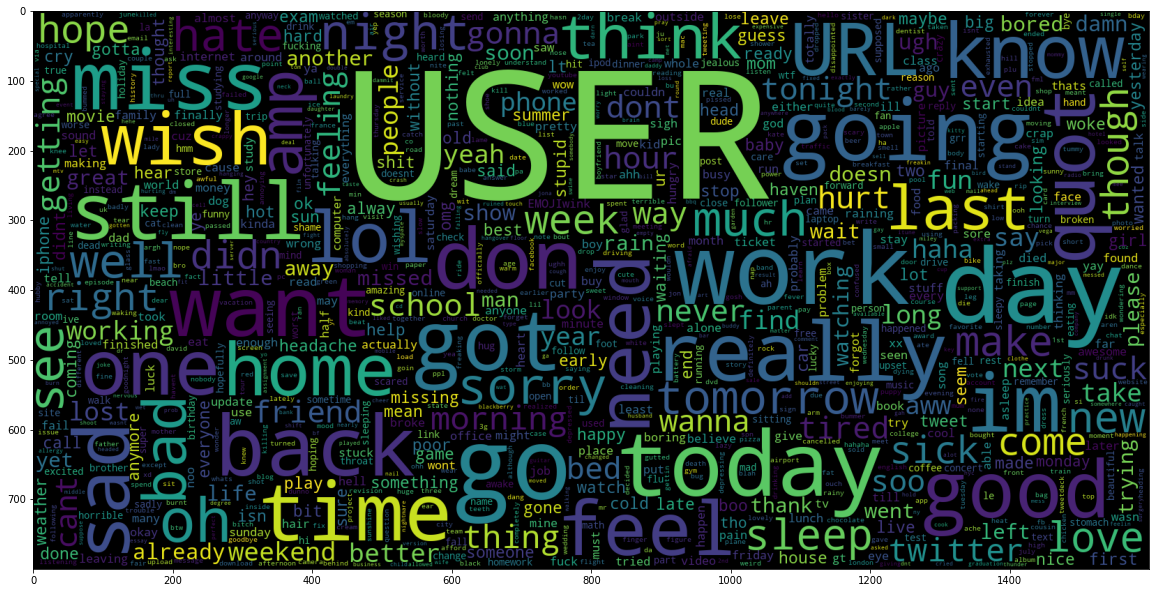

In [ ]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

## **Word-Cloud for Positive  Tweets**

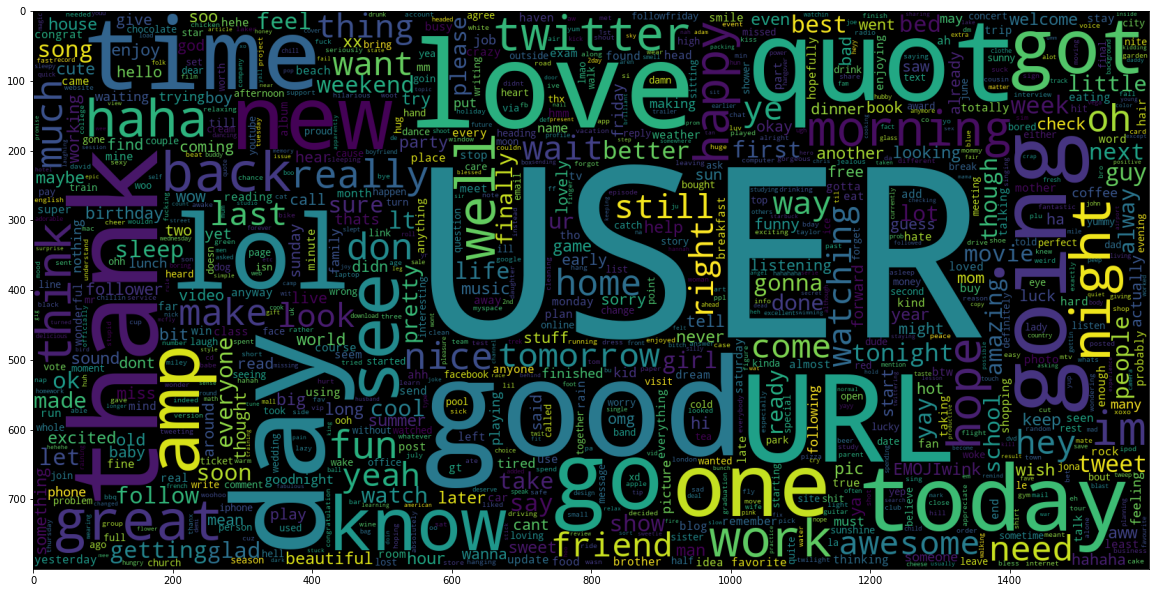

In [ ]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

# Train-Test Split

In [ ]:
X=data1['text']
y=data1['class']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [ ]:
# Concatening X_train and Y_train
training_data= pd.concat([X_train, y_train], axis=1, join='inner')
training_data.head()

,text,class
706209,woke gonna go take maalox ugghh hate stinkin g...,0
200654,tummy hurt,0
1002643,USER good night mr thrillbilly,1
883708,idiotat pjaficianado th nks follow dammitdao i...,1
929563,great day love today picnic subway playground ...,1


In [ ]:
# Concatening X_test and Y_test
testing_data= pd.concat([X_test, y_test], axis=1, join='inner')
testing_data.head()

,text,class
1016244,happy birthday sister,1
1303317,finished eating supper attacking daddy,1
576684,hate love right,0
837327,photo fest ldn tudor feast last night don thin...,1
985344,USER happy bday tomoz best people born may,1


In [ ]:
# Reseting Indexes of testing and training data
testing_data.reset_index(drop=True, inplace=True)
training_data.reset_index(drop=True, inplace=True)

# Encoding of Data

Tokenizer : 
	Natural language processing is one of the fields in programming where the natural language is processed by the software. This has many applications like sentiment analysis, language translation, fake news detection, grammatical error detection etc.

The input in natural language processing is text. The data collection for this text happens from a lot of sources. This requires a lot of cleaning and processing before the data can be used for analysis.

5   methods:

Tokenizer

Batch Encode plus

Encode_plus

Encode

Tokenize and then get_token_ids


Importing Tokenizer

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Encoding of text using BERT

In [ ]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
        
        data.text[i],
        add_special_tokens=True,       # Adding special Tokens CLS and SEP
        max_length=maximum_length,     # Max length number of words present in sentence
        pad_to_max_length=True,        # Adding Padding
        
        return_attention_mask=True,
        
      )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Getting Input ids and Attention masks for traing and testing data

In [ ]:
#  As Dataset is lot bigger that's why slicing is done 400000 rows of training data and 10000 rows of testing data are considered for model
train_input_ids,train_attention_masks = bert_encode(training_data[:400000],60)
test_input_ids,test_attention_masks = bert_encode(testing_data[:10000],60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Model Creation

In [ ]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    
    output = bert_model.bert([input_ids,attention_masks])
    output = output[1]
    
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

Importing BERT Model

In [ ]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model(bert_model)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_17[0][0]',               
                                thPoolingAndCrossAt               'input_18[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model1 = create_model(bert_model)
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_7 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_9[0][0]',                
                                thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Visualising the model

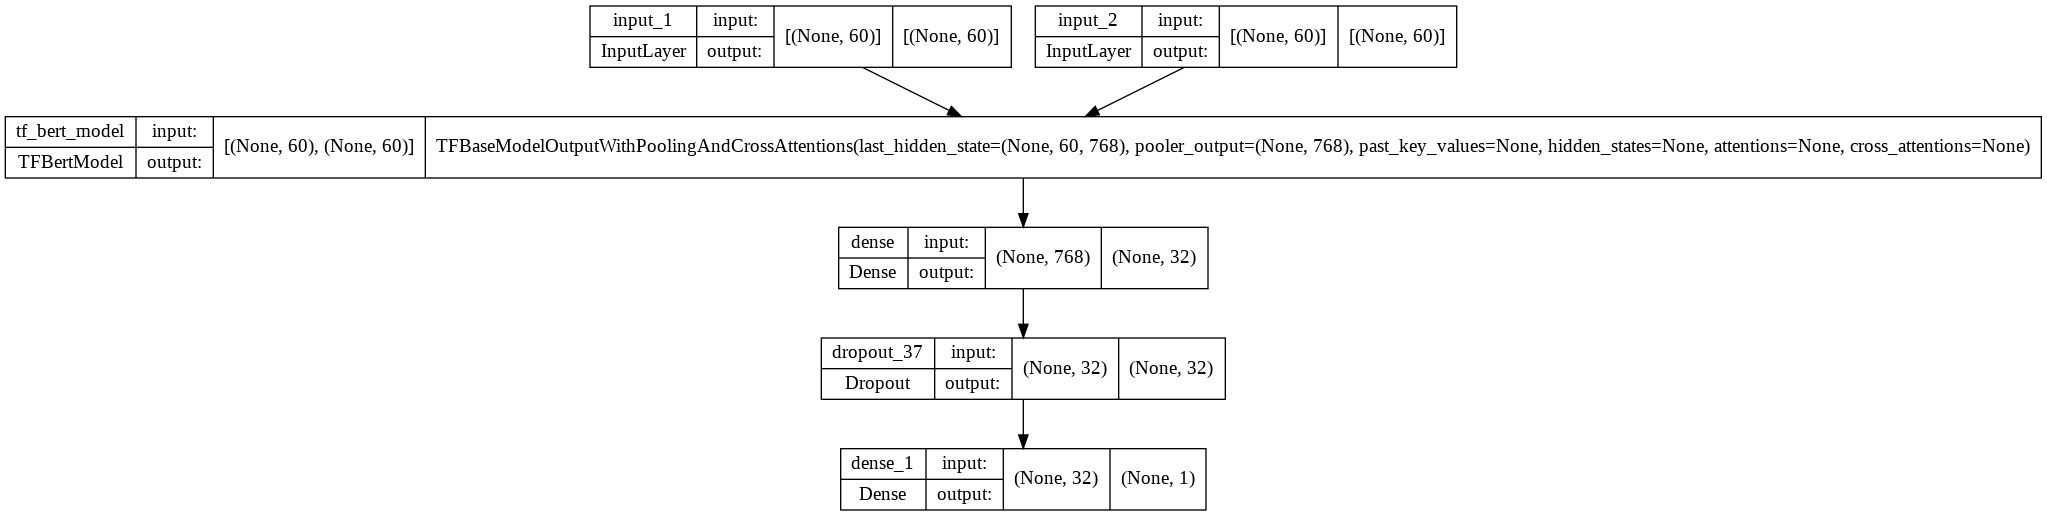

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', expand_nested=True, show_shapes=True)

In [ ]:
dummy=training_data[:400000]
targets = dummy['class'].values

dummy2=testing_data[:10000]
targets_y = dummy2['class'].values

In [ ]:
history = model.fit([train_input_ids,train_attention_masks],targets,validation_data=([test_input_ids,test_attention_masks],targets_y), epochs=2,batch_size=64)

Epoch 1/2
6250/6250 [==============================] - 9138s 1s/step - loss: 0.3962 - accuracy: 0.8213 - val_loss: 0.3569 - val_accuracy: 0.8430
Epoch 2/2
6250/6250 [==============================] - 9052s 1s/step - loss: 0.3424 - accuracy: 0.8507 - val_loss: 0.3481 - val_accuracy: 0.8493


Saving Model

In [ ]:
model.save('/content/drive/MyDrive/Models/projectModel.hdf5')

# Accuracy and Loss curves

Accuracy Curve

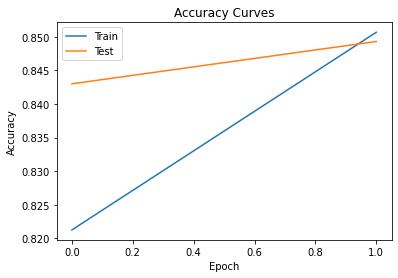

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Loss Curve

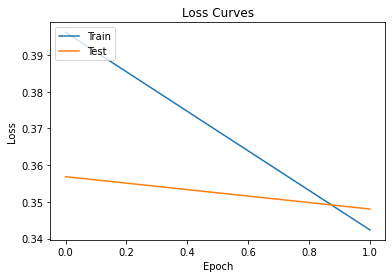

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Classification Report

In [ ]:
y_pred=model.predict(([test_input_ids,test_attention_masks]))

In [ ]:
for i in range(len(y_pred)):
  if y_pred[i]>0.5:
    y_pred[i]=1        #  Positive 
  else:
    y_pred[i]=0        #  Negative

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(targets_y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      5037
           1       0.86      0.83      0.84      4963

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



# Making Predictions for data provided by user

Loading model

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Models/projectModel.hdf5',custom_objects={'TFBertModel':TFBertModel})

In [ ]:


def make_prediction(model, processed_data):
    probs = model.predict(processed_data)
    print(probs)
    if probs<=0.5:
      return 'Negative'
    else:
      return 'Positive'  
    

In [ ]:
def bert_encode_input(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
input_text1 = ['I hate You']
processed_input1=preprocess(input_text1)
print(processed_input1)
input_input_ids1,input_attention_masks1 = bert_encode_input(processed_input1,60)
print(input_input_ids1)
result1=make_prediction(new_model, [input_input_ids1,input_attention_masks1])
print(f"Predicted Sentiment: {result1}")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['hate ']
[[ 101 5223  102    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[0.0124861]]
Predicted Sentiment: Negative


In [ ]:
input_text2 = ['is upset that he can update his facebook by texting it and might cry a result school today also blah']
processed_input2=preprocess(input_text2)
processed_input2
input_input_ids2,input_attention_masks2 = bert_encode_input(processed_input2,60)
result2=make_prediction(new_model, [input_input_ids2,input_attention_masks2])
print(f"Predicted Sentiment: {result2}")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[0.01565874]]
Predicted Sentiment: Negative


# Deployment of Model

In [ ]:
import tempfile
import os
MODEL_DIR = "/content/gdrive/My Drive/bert_model"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    new_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = /content/gdrive/My Drive/bert_model/1



INFO:tensorflow:Assets written to: /content/gdrive/My Drive/bert_model/1/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/bert_model/1/assets


Path to Saved Model :- 

In [ ]:
export_path = /content/gdrive/My Drive/bert_model/1

Check the model stats using saved model cli :-

In [ ]:
! saved_model_cli show --dir '/content/gdrive/My Drive/bert_model/1' --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 60)
        name: serving_default_input_1:0
    inputs['input_2'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 60)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functi

Installation of TF Serving on Server :-

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  19490      0 --:--:-- --:--:-- --:--:-- 19490
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://storage.googleapis.com/tensorflow-serving

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 69 not upgraded.
Need to get 340 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.8.0 [340 MB]
Fetched 340 MB in 5s (71.8 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-model-server (2.8.0) ...


In [ ]:
MODEL_DIR="/content/gdrive/My Drive/bert_model"

Set the path of model to operating system variable :-

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

Start the server in background 

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=bert_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


Check server log :-

In [ ]:
!tail server.log

2022-03-21 23:03:49.868155: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 93763584 exceeds 10% of free system memory.
2022-03-21 23:03:49.871718: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 93763584 exceeds 10% of free system memory.
2022-03-21 23:03:49.880740: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 93763584 exceeds 10% of free system memory.
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## Client Side Implementation

In [ ]:
input_input_ids2,input_attention_masks2

(array([[  101,  6314, 10651,  9130,  3793,  2075,  2453,  5390,  2765,
          2082,  2651,  2036, 27984,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]),
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

Dump the input in json format as expected in TF serving :-

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "inputs": {'input_1' : input_input_ids2.tolist(),'input_2' : input_attention_masks2.tolist() } })
print('Data: {} ... {}'.format(data, len(data)))

Data: {"signature_name": "serving_default", "inputs": {"input_1": [[101, 6314, 10651, 9130, 3793, 2075, 2453, 5390, 2765, 2082, 2651, 2036, 27984, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "input_2": [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}} ... 481


Install request library so that requests can be sent to the server and send the json request to the server, get a response in variable :-

In [ ]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/bert_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)
print(predictions)
class_names={0:'Negative', 1:'Positive'}
print(round(predictions['outputs'][0][0]))
print("Sentiment Class of given Sentence is : {}".format(class_names[round(predictions['outputs'][0][0])]))

{'outputs': [[0.0156587362]]}
0
Sentiment Class of given Sentence is : Negative
